# CONTINUAL LEARNING ENABLED VISION FOUNDATION MODEL FOR SHIPPING CONTAINER DEFECT SEGMENTATION

```
Student: Feras Hamid Banday

Supervisor: Dr. Loo Chu Kiong

Matric: 22073684
```

### PROJECT OVERVIEW

This notebook implements a continual learning framework for container defect
segmentation using DINOv3 as the backbone and various CL strategies from
Mammoth library.

### Architecture:
- **Backbone:** DINOv3 (frozen, pre-trained)
- **Decoder:** Lightweight segmentation head (trainable)
- **CL Strategies:** ER, ER-ACE, DER/DER++

### Goals:
1. Train baseline model (all tasks at once)
2. Implement task-incremental learning
3. Compare CL strategies vs catastrophic forgetting
4. Benchmark performance: Average Accuracy, Backward Transfer, Forward Transfer

## **SECTION 1: CONFIGURATION**

All hyperparameters and paths defined here for easy modification.

In [ ]:
# Paths
ZIP_PATH = "/content/drive/MyDrive/TAO Checkpoint.v2-v0-bin.png-mask-semantic.zip"
DATASET_ROOT = "/content/dataset"
TRAIN_DIR = f"{DATASET_ROOT}/train"
VALID_DIR = f"{DATASET_ROOT}/valid"
SAVE_DIR = "/content/drive/MyDrive/FYP_Models"

# Model Configuration
BACKBONE = "vitl16"         # DINOv3 variant: vits16, vitb16, vitl16, vith16
NUM_CLASSES = 2             # Binary: background + defect
IMAGE_SIZE = 768            # must be divisible by PATCH_SIZE
PATCH_SIZE = 16
DECODER_HIDDEN_DIM = 256
DROPOUT = 0.1               # Dropout probability

# Training Configuration
BATCH_SIZE = 8
LEARNING_RATE = 1e-3
NUM_EPOCHS = 1
SUBSET_SIZE = 10

# Continual Learning Configuration
NUM_TASKS = 3
MEMORY_SIZE = 500           # Replay buffer size for ER/DER

print("Configuration loaded")

Configuration loaded


## **SECTION 2: ENVIRONMENT SETUP**

Install dependencies and prepare environment

In [ ]:
# Install Dependencies
!pip install -q torch torchvision pillow numpy matplotlib tqdm transformers huggingface_hub
print("Dependencies installed")

Dependencies installed


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# HuggingFace Authentication
from huggingface_hub import login
from google.colab import userdata
login(token=userdata.get('HF_TOKEN'))
print("HuggingFace authenticated")

HuggingFace authenticated


In [ ]:
# Extract Dataset
import os
import zipfile

os.makedirs(SAVE_DIR, exist_ok=True)

if not os.path.exists(DATASET_ROOT):
  print(f"Extracting dataset to {DATASET_ROOT}")
  with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(DATASET_ROOT)
    print("Dataset extracted")
else:
  print("Dataset already extracted")

# Verify
train_count = len([f for f in os.listdir(TRAIN_DIR) if f.endswith('.jpg')])
valid_count = len([f for f in os.listdir(VALID_DIR) if f.endswith('.jpg')])
print(f"Dataset verified: {train_count} train, {valid_count} valid images")

Dataset already extracted
Dataset verified: 2974 train, 1274 valid images


## **SECTION 3: DATA PIPELINE**

**Dataset Class**

Loads container images and binary defect masks.
```
  -  Resizes to 768x768 (compatible with DINOv3 patches)
  -  Applies ImageNet normalization
  -  Handles [0,1] mask values properly
```






In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
from typing import Tuple, Optional, List

class ContainerDefectDataset(Dataset):
  """Dataset for shipping container defect segmentation"""

  def __init__(
      self,
      root_dir: str,
      image_size: int = IMAGE_SIZE,
      patch_size: int = PATCH_SIZE,
      subset_size: Optional[int] = None
  ):

    assert image_size % patch_size == 0, "Image size must be divisible by patch size"
    self.root_dir = root_dir
    self.image_size = image_size
    self.patch_size = patch_size

    # Collect image files
    all_files = sorted(os.listdir(root_dir))
    self.image_files: List[str] = [
        f for f in all_files if f.lower().endswith(".jpg")
    ]

    if subset_size is not None:
      self.image_files = self.image_files[:subset_size]

    self._verify_masks()

    # Image transform: resize + normalize
    self.image_transform = T.Compose([
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
        ),
    ])

    # Mask transform: resize + scale [0,1]->[0,1]
    self.mask_transform = T.Compose([
        T.Resize(
            (image_size, image_size),
            interpolation=T.InterpolationMode.NEAREST
        ),
        T.ToTensor(),
        T.Lambda(lambda x: x * 255.0), # masks stored as [0,1] not [0,255]
    ])

    print(f"Loaded {len(self.image_files)} samples from {root_dir}")

  def _verify_masks(self):
    """Verify all masks exist"""
    missing = []
    for img in self.image_files:
      base = os.path.splitext(img)[0]
      mask_path = os.path.join(
          self.root_dir, base + "_mask.png")
      if not os.path.exists(mask_path):
        missing.append(mask_path)
    if missing:
      raise FileNotFoundError(f"Missing {len(missing)} masks")

  def __len__(self) -> int:
    return len(self.image_files)


  def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, str]:
    img_name = self.image_files[idx]
    base = os.path.splitext(img_name)[0]
    mask_name = base + "_mask.png"

    img_path = os.path.join(self.root_dir, img_name)
    mask_path = os.path.join(self.root_dir, mask_name)

    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    image = self.image_transform(image)
    mask = self.mask_transform(mask)
    mask = (mask > 0.5).float() # binarize

    return image, mask, img_name

  def patch_grid(self) -> Tuple[int, int]:
    """Returns (H_patches, W_patches)"""
    n = self.image_size // self.patch_size
    return n, n

## **SECTION 4: MODEL ARCHITECTURE**


**DINOv3 Backbone**
*   Self-supervised vision transformer
*   Extracts dense patch features (48x48 grid for 768px images)
*   Frozen during training (only decoder is trainer)

<br>

**Segmentation Head**
*   Lightweight CNN decoder
*   Progressive upsampling: 48->96->192->384->768
*   Trainable parameters: ~2.7M (vs 303M frozen in DINOv3)


In [ ]:
import torch.nn as nn
from transformers import AutoModel




###**DINOv3 Feature Extractor**




In [ ]:
class DINOv3FeatureExtractor(nn.Module):
  """Extracts dense features from DINOv3 backbone"""

  MODEL_REGISTRY = {
      "vits16": "facebook/dinov3-vits16-pretrain-lvd1689m",
      "vitsp16": "facebook/dinov3-vits16plus-pretrain-lvd1689m",
      "vitb16": "facebook/dinov3-vitb16-pretrain-lvd1689m",
      "vitl16": "facebook/dinov3-vitl16-pretrain-lvd1689m",
      "vithp16": "facebook/dinov3-vith16plus-pretrain-lvd1689m",
      # "vit7b16": "facebook/dinov3-vit7b16-pretrain-lvd1689m",
  }

  # # Number of layers for each model
  # NUM_LAYERS = {
  #     "vits16": 12,
  #     "vitsp16": 12,
  #     "vitb16": 12,
  #     "vitl16": 24,
  #     "vithp16": 32,
  #     # "vit7b16": 40,
  # }

  # Feature dimensions for each model
  FEATURE_DIMS = {
      "vits16": 384,
      "vitsp16": 384,
      "vitb16": 768,
      "vitl16": 1024,
      "vithp16": 1280,
      # "vit7b16": 1536,
  }

  def __init__(
      self,
      model_name: str = BACKBONE,
      patch_size: int = PATCH_SIZE,
      freeze: bool = True,
  ):
    super().__init__()
    self.model_name = model_name
    self.patch_size = patch_size
    # self.num_layers = self.NUM_LAYERS[model_name]
    self.feature_dim = self.FEATURE_DIMS[model_name]

    # Load pre-trained model
    self.backbone = AutoModel.from_pretrained(self.MODEL_REGISTRY[model_name])

    if freeze:
        for param in self.backbone.parameters():
            param.requires_grad = False

    self.backbone.eval()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    B, C, H, W = x.shape
    H_patches, W_patches = H // self.patch_size, W // self.patch_size

    with torch.set_grad_enabled(not self.training):
      outputs = self.backbone(
          x,
          output_hidden_states=True,
          return_dict=True
      )

    # Extract spatial patch tokens (skip CLS + register tokens)
    last_layer = outputs.hidden_states[-1]
    num_patch_tokens = H_patches * W_patches
    patch_tokens = last_layer[:, 1:1+num_patch_tokens, :]

    # Reshape to spatial grid
    features = patch_tokens.reshape(B, H_patches, W_patches, self.feature_dim)
    return features.permute(0, 3, 1, 2)

  def get_feature_dim(self) -> int:
    return self.feature_dim


###**Segmentation Head (Decoder)**

In [ ]:
class SegmentationHead(nn.Module):
  """Upsamples features to pixel-wise predictions"""

  def __init__(
      self,
      in_channels: int,
      num_classes: int = NUM_CLASSES,
      hidden_dim: int = DECODER_HIDDEN_DIM,
      dropout: float = DROPOUT,
  ):
    super().__init__()

    # 48→96→192→384→768 progressive upsampling
    self.layer1 = self._make_layer(in_channels, hidden_dim, dropout)
    self.layer2 = self._make_layer(hidden_dim, hidden_dim // 2, dropout)
    self.layer3 = self._make_layer(hidden_dim // 2, hidden_dim // 4, dropout)
    self.layer4 = self._make_layer(hidden_dim // 4, hidden_dim // 8, dropout)
    self.classifier = nn.Conv2d(hidden_dim // 8, num_classes, kernel_size=1)

  def _make_layer(self, in_ch, out_ch, dropout):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout2d(dropout),
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
  )

  def forward(self, features: torch.Tensor) -> torch.Tensor:
    x = self.layer1(features)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    return self.classifier(x)

### **Complete Model**

In [ ]:
class ContainerDefectSegmenter(nn.Module):
  """Complete segmentation model: DINOv3 + Decoder"""

  def __init__(
      self,
      backbone_name: str = BACKBONE,
      num_classes: int = NUM_CLASSES,
      freeze_backbone: bool = True,
      decoder_hidden_dim: int = DECODER_HIDDEN_DIM,
  ):
    super().__init__()

    self.backbone = DINOv3FeatureExtractor(
        model_name=backbone_name,
        freeze=freeze_backbone
    )

    # Segmentation head (decoder)
    self.head = SegmentationHead(
        self.backbone.get_feature_dim(),
        num_classes,
        decoder_hidden_dim
    )

    self.num_classes = num_classes

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    features = self.backbone(x)
    return self.head(features)

  def predict(self, x: torch.Tensor) -> torch.Tensor:
    return torch.argmax(self.forward(x), dim=1)

## **SECTION 5: TRAINING UTILITIES**

**Training & Evaluation**

Metrics:
*   **IoU (Intersection over Union):** Standard segmentation metric
*   **Pixel Accuracy:** Percentage of correctly classified pixels



In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

In [ ]:
# Metrics

def compute_iou(predictions, targets, num_classes=2):
  """Compute mean IoU across classes"""
  ious = []
  for cls in range(num_classes):
    pred_mask = (predictions == cls)
    true_mask = (targets == cls)
    intersection = (pred_mask & true_mask).sum().float()
    union = (pred_mask | true_mask).sum().float()
    iou = (intersection / union).item() if union > 0 else float('nan')
    ious.append(iou)
  valid_ious = [iou for iou in ious if not np.isnan(iou)]
  return ious, np.mean(valid_ious) if valid_ious else 0.0


def compute_pixel_accuracy(predictions, targets):
  """Compute pixel-wise accuracy"""
  correct = (predictions == targets).sum().float()
  return (correct / targets.numel()).item()

In [ ]:
# Training Loop

def train_one_epoch(model, dataloader, criterion, optimizer, device):
  """Train for one epoch"""
  model.train()
  total_loss, total_iou, total_acc, num_batches = 0.0, 0.0, 0.0, 0

  for images, masks, _ in tqdm(dataloader, desc="Training", leave=False):
    images = images.to(device)
    targets = masks.squeeze(1).long().to(device)

    # Forward pass
    optimizer.zero_grad()
    logits = model(images)

    # Compute loss
    loss = criterion(logits, targets)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Compute metrics
    predictions = torch.argmax(logits, dim=1)
    _, iou = compute_iou(predictions, targets)
    acc = compute_pixel_accuracy(predictions, targets)

    # Accumulate
    total_loss += loss.item()
    total_iou += iou
    total_acc += acc
    num_batches += 1

  return total_loss / num_batches, total_iou / num_batches, total_acc / num_batches

@torch.no_grad()
def validate(model, dataloader, criterion, device):
  """Validate the model"""
  model.eval()
  total_loss, total_iou, total_acc, num_batches = 0.0, 0.0, 0.0, 0

  for images, masks, _ in tqdm(dataloader, desc="Validation", leave=False):
    images = images.to(device)
    targets = masks.squeeze(1).long().to(device)

    # Forward pass
    logits = model(images)

    # Compute loss
    loss = criterion(logits, targets)

    # Compute metrics
    predictions = torch.argmax(logits, dim=1)
    _, iou = compute_iou(predictions, targets)
    acc = compute_pixel_accuracy(predictions, targets)

    # Accumulate
    total_loss += loss.item()
    total_iou += iou
    total_acc += acc
    num_batches += 1

  return total_loss / num_batches, total_iou / num_batches, total_acc / num_batches

In [ ]:
# Main Training Function

def train_baseline_model(
    train_dir=TRAIN_DIR, valid_dir=VALID_DIR,
    num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, lr=LEARNING_RATE,
    subset_size=SUBSET_SIZE, save_path=f"{SAVE_DIR}/baseline_model.pth"
):
  """Train the baseline model (*all data at once, no CL*)"""
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Datasets
  train_dataset = ContainerDefectDataset(train_dir, subset_size=subset_size)

  val_dataset = ContainerDefectDataset(
      valid_dir,
      subset_size=subset_size // 2 if subset_size else None
  )

  # Dataloaders
  train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=2,
      pin_memory=True
  )

  val_loader = DataLoader(
      val_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=2,
      pin_memory=True
  )

  # Model
  model = ContainerDefectSegmenter().to(device)

  trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(
      filter(lambda p: p.requires_grad, model.parameters()),
      lr=lr
  )
  print(f"\nBASELINE TRAINING\n")
  print(f"Device: {device}")
  print(f"Train: {len(train_dataset)} images | Val: {len(val_dataset)} images")
  print(f"Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}\n")

  best_val_iou = 0.0
  for epoch in range(num_epochs):
    # Train
    train_loss, train_iou, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    # Validate
    val_loss, val_iou, val_acc = validate(
        model, val_loader, criterion, device
    )
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train:  Loss={train_loss:.4f}, IoU={train_iou:.4f}, Acc={train_acc:.4f}")
    print(f"  Val:    Loss={val_loss:.4f}, IoU={val_iou:.4f}, Acc={val_acc:.4f}")

    # Save best model
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), save_path)
        print(f"Saved best model (IoU: {val_iou:.4f})")

  print("\n" + "=" * 60)
  print(f"Training complete | Best IoU: {best_val_iou:.4f}")
  print(f"Model saved: {save_path}")
  return model

In [ ]:
# Load saved model

def load_trained_model(model_path, device='cuda'):
  """Load a saved model checkpoint"""
  model = ContainerDefectSegmenter(
      backbone_name=BACKBONE,
      num_classes=NUM_CLASSES,
      freeze_backbone=True,
      decoder_hidden_dim=DECODER_HIDDEN_DIM,
  )

  # Load weights
  model.load_state_dict(torch.load(model_path, map_location=device))
  model = model.to(device)
  model.eval()

  print(f"Model loaded from: {model_path}")
  return model



```
This trains the model (no continual learning).

If complete dataset used, it serves as the upper-bound performamce for CL strategies to compare against.

Uncomment the line below to train or load.
```



In [ ]:
# baseline_model = train_baseline_model()

baseline_model = load_trained_model(f"{SAVE_DIR}/baseline_model.pth")

RuntimeError: PytorchStreamReader failed locating file data/43: file not found

## **SECTION 6: CONTINUAL LEARNING FRAMEWORK**

This section implements task-incremental learning where the model learns defects sequentially (Task 1 -> Task 2 -> Task 3) instead of all at once.

<br>

### CL Methods:
*   **Replay-based:** ER, ER-ACE, DER/DER++
*   **Baseline:** Naive fine-tuning (no CL)

<br>

### Evaluation Metrics:
*   **Average Accuracy:** Performance across all tasks
*   **Backward Transfer:** How much old tasks degrade
*   **Forward Transfer:** Does new learning help old tasks?




In [ ]:
from torch.utils.data import Subset
from abc import ABC, abstractmethod
import random
import copy
import json

### **Part 1: Task Splitting**

Split the dataset into sequential tasks for continual learning.

**Strategy:** Random Split (can change to class-based split later)

- Task 1: First N/3 images
- Task 2: Next N/3 images
- Task 3: Last N/3 images

In [ ]:
class TaskIncrementalDataset:
  """Splits dataset into sequential tasks for continual learning"""
  def __init__(
      self,
      base_dataset: ContainerDefectDataset,
      num_tasks: int = NUM_TASKS,
      shuffle_before_split: bool = True,
      seed: int = 42
  ):
    self.base_dataset = base_dataset
    self.num_tasks = num_tasks
    self.seed = seed

    total_size = len(base_dataset)
    indices = list(range(total_size))

    if shuffle_before_split:
      random.seed(seed)
      random.shuffle(indices)

    task_size = total_size // num_tasks
    self.task_indices = []

    for task_id in range(num_tasks):
      start_idx = task_id * task_size
      end_idx = total_size if task_id == num_tasks - 1 else (task_id + 1) * task_size
      self.task_indices.append(indices[start_idx:end_idx])
    print(f"Split {total_size} images into {num_tasks} tasks:")
    for i, task_idx in enumerate(self.task_indices):
      print(f"   Task{i+1}: {len(task_idx)} images")

  def get_task_dataset(self, task_id: int) -> Subset:
    assert 0 <= task_id < self.num_tasks
    return Subset(self.base_dataset, self.task_indices[task_id])

  def get_task_loader(
      self,
      task_id: int,
      batch_size: int = BATCH_SIZE,
      shuffle: bool = True,
  ) -> DataLoader:
    task_dataset = self.get_task_dataset(task_id)
    return DataLoader(
        task_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=2,
        pin_memory=True
    )

  def get_all_tasks_until(self, task_id: int) -> Subset:
    combined_indices = []
    for i in range(task_id + 1):
      combined_indices.extend(self.task_indices[i])
    return Subset(self.base_dataset, combined_indices)

### **Part 2: Replay Buffer**

**Experience Replay Buffer**

Stores samples from previous tasks to prevent catastrophic forgetting.

In [ ]:
class ReplayBuffer:
  """Stores (image, mask) pairs from previous tasks"""

  def __init__(self, max_size: int = MEMORY_SIZE):
    self.max_size = max_size
    self.buffer = []
    self.task_counts = {}

  def add_samples(self, images, masks, filenames, task_id):
    batch_size = images.shape[0]

    for i in range(batch_size):
      if len(self.buffer) < self.max_size:
        self.buffer.append({
            'image': images[i].cpu,
            'mask': masks[i].cpu,
            'filename': filenames[i],
            'task_id': task_id
        })
        self.task_counts[task_id] = self.task_counts.get(task_id, 0) + 1
      else:
        # Buffer full, use reservoir sampling
        idx = random.randint(0, len(self.buffer) - 1)
        old_task = self.buffer[idx]['task_id']
        self.task_counts[old_task] -= 1

        self.buffer[idx] = {
            'image': images[i].cpu(),
            'mask': masks[i].cpu(),
            'filename': filenames[i],
            'task_id': task_id
        }
        self.task_counts[task_id] = self.task_counts.get(task_id, 0) + 1

  def sample(self, batch_size: int, device='cuda'):
    if len(self.buffer) == 0:
      return None, None

    sample_size = min(batch_size, len(self.buffer))
    samples = random.sample(self.buffer, sample_size)

    images = torch.stack([s['image'] for s in samples]).to(device)
    masks = torch.stack([s['mask'] for s in samples]).to(device)

    return images, masks

  def __len__(self):
    return len(self.buffer)

  def get_stats(self):
    return {
        'total': len(self.buffer),
        'max_size': self.max_size,
        'task_distribution': self.task_counts
    }


### **Part 3: CL Evaluation Metrics**

Track performance across tasks to measure forgetting and transfer.

In [ ]:
class CLMetricsTracker:
  """Tracks CL metrics: Average Accuracy, Backward Transfer, Forgetting"""
  def __init__(self, num_tasks: int = NUM_TASKS):
    self.num_tasks = num_tasks
    self.accuracy_matrix = np.zeros((num_tasks, num_tasks))
    self.task_names = [f"Task {i+1}" for i in range(num_tasks)]

  def update(self, current_task: int, task_accuracies: dict):
    for task_id, acc in task_accuracies.items():
      self.accuracy_matrix[current_task][task_id] = acc

  def compute_average_accuracy(self, up_to_task: int):
    accs = []
    for task_id in range(up_to_task + 1):
      acc = self.accuracy_matrix[up_to_task][task_id]
      if acc > 0:
        accs.append(acc)
    return np.mean(accs) if accs else 0.0

  def compute_forgetting(self, up_to_task: int):
    if up_to_task == 0:
      return 0.0

    forgettings = []
    for task_id in range(up_to_task):
      max_acc = np.max(self.accuracy_matrix[:up_to_task+1, task_id])
      current_acc = self.accuracy_matrix[up_to_task][task_id]
      forgetting = max_acc - current_acc
      forgettings.append(forgetting)

    return np.mean(forgettings) if forgettings else 0.0

  def compute_backward_transfer(self):
    if self.num_tasks < 2:
      return 0.0

    bwt_scores = []
    for task_id in range(self.num_tasks - 1):
      initial_acc = self.accuracy_matrix[task_id][task_id]
      final_acc = self.accuracy_matrix[- 1][task_id]
      bwt = final_acc - initial_acc
      bwt_scores.append(bwt)

    return np.mean(bwt_scores) if bwt_scores else 0.0

  def get_summary(self):
    return {
        'Average Accuracy': self.compute_average_accuracy(self.num_tasks - 1),
        'Forgetting': self.compute_forgetting(self.num_tasks - 1),
        'Backward Transfer': self.compute_backward_transfer(),
        'Accuracy Matrix': self.accuracy_matrix.tolist()
    }

  def print_summary(self):
    print("\nCL METRICS SUMMARY")
    print("\nAccuracy Matrix (rows= after task X, cols= on task Y)")
    print("       ", end="")
    for i in range(self.num_tasks):
        print(f"T{i+1:2d}   ", end="")
    print()

    for i in range(self.num_tasks):
      print(f"After T{i+1}: ", end="")
      for j in range(self.num_tasks):
        acc = self.accuracy_matrix[i][j]
        if acc > 0:
          print(f"{acc:.3f} ", end="")
        else:
          print("  -   ", end="")
      print()

    print("Summary")
    print(f"  Average Accuracy:  {self.compute_average_accuracy(self.num_tasks-1):.4f}")
    print(f"  Forgetting:        {self.compute_forgetting(self.num_tasks-1):.4f}")
    print(f"  Backward Transfer: {self.compute_backward_transfer():.4f}")


### **Part 4: Base CL Strategy**

Abstract base class for all CL strategies.

In [ ]:
from abc import ABC, abstractmethod

class BaseCLStrategy(ABC):

  def __init__(
      self,
      model: ContainerDefectSegmenter,
      device: str = 'cuda',
      lr: float = LEARNING_RATE,
  ):
    self.model = model.to(device)
    self.device = device
    self.lr = lr
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr
    )

  @abstractmethod
  def train_task(
      self,
      task_loader: DataLoader,
      task_id: int,
      num_epochs: int = NUM_EPOCHS
  ):
    pass

  @abstractmethod
  def after_task(self, task_loader: DataLoader, task_id: int):
    pass

  def evaluate_on_task(self, task_loader: DataLoader):
    self.model.eval()
    total_iou, total_acc, num_batches = 0.0, 0.0, 0

    with torch.no_grad():
      for images, masks, _ in task_loader:
        images = images.to(self.device)
        targets = masks.squeeze(1).long().to(self.device)

        logits = self.model(images)
        predictions = torch.argmax(logits, dim=1)

        _, iou = compute_iou(predictions, targets)
        acc = compute_pixel_accuracy(predictions, targets)

        total_iou += iou
        total_acc += acc
        num_batches += 1

    return total_iou / num_batches if num_batches > 0 else 0.0, total_acc / num_batches if num_batches > 0 else 0.0

In [ ]:
# # Test Task Splitting
# # Create task-incremental dataset
# print("\n" + "="*60)
# print("TESTING TASK SPLITTING")
# print("="*60)

# train_dataset = ContainerDefectDataset(TRAIN_DIR, subset_size=SUBSET_SIZE)
# task_split = TaskIncrementalDataset(
#     train_dataset,
#     num_tasks=NUM_TASKS,
#     shuffle_before_split=True
# )

# # Show task loaders
# print("\n✓ Task loaders created:")
# for task_id in range(NUM_TASKS):
#     loader = task_split.get_task_loader(task_id, batch_size=BATCH_SIZE)
#     print(f"  Task {task_id+1}: {len(loader)} batches")

# print("\n✓ Task splitting test complete!")

### **Part 5: CL Strategies**

Implement different continual learning approaches:


1.   **Naive Fine-tuning:** No CL, just sequential just sequential training (baseline for forgetting)
2.   **ER (Experience Replay):** Store samples, replay during training
3.   **DER++ (Dark Experience REplay):** ER + logit distillation



**Strategy 1: Naive Fine-tuning**

In [ ]:
class NaiveFineTuning(BaseCLStrategy):
  """Baseline: Just train sequentially without any CL strategy"""

  def __init__(self, model, device='cuda', lr=LEARNING_RATE):
    super().__init__(model, device, lr)
    self.name = "Naive Fine-tuning"

  def train_task(self, task_loader, task_id, num_epochs=NUM_EPOCHS):
    self.model.train()
    print(f"Training Task {task_id+1} - {self.name}")

    for epoch in range(num_epochs):
      total_loss, total_iou, num_batches = 0.0, 0.0, 0

      for images, masks, _ in tqdm(task_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        images = images.to(self.device)
        targets = masks.squeeze(1).long().to(self.device)

        self.optimizer.zero_grad()
        logits = self.model(images)
        loss = self.criterion(logits, targets)
        loss.backward()
        self.optimizer.step()

        predictions = torch.argmax(logits, dim=1)
        _, iou = compute_iou(predictions, targets)

        total_loss += loss.item()
        total_iou += iou
        num_batches += 1

      avg_loss = total_loss / num_batches
      avg_iou = total_iou / num_batches
      print(f"  Epoch {epoch+1}: Loss={avg_loss:.4f}, IoU={avg_iou:.4f}")
    return {'loss': avg_loss, 'iou': avg_iou}

  def after_task(self, task_loader, task_id):
    pass


**Strategy 2: Experience Replay (ER)**

In [ ]:
class ExperienceReplay(BaseCLStrategy):
    """Experience Replay: Store samples from old tasks and replay during training"""

    def __init__(self, model, device='cuda', lr=LEARNING_RATE,
                 buffer_size=MEMORY_SIZE, samples_per_task=100):
        super().__init__(model, device, lr)
        self.name = "Experience Replay (ER)"
        self.buffer = ReplayBuffer(max_size=buffer_size)
        self.samples_per_task = samples_per_task

    def train_task(self, task_loader, task_id, num_epochs=NUM_EPOCHS):
        """Train on current task + replay samples"""
        self.model.train()

        print(f"Training Task {task_id+1} - {self.name}")
        print(f"Buffer: {len(self.buffer)}/{self.buffer.max_size} samples")

        for epoch in range(num_epochs):
          total_loss, total_iou, num_batches = 0.0, 0.0, 0

          for images, masks, filenames in tqdm(task_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            images = images.to(self.device)
            targets = masks.squeeze(1).long().to(self.device)

            # Get replay samples if buffer not empty
            if len(self.buffer) > 0:
              replay_images, replay_masks = self.buffer.sample(
                  batch_size=images.shape[0] // 2,  # Half batch from buffer
                  device=self.device
              )

              if replay_images is not None:
                  images = torch.cat([images, replay_images], dim=0)
                  replay_targets = replay_masks.squeeze(1).long()
                  targets = torch.cat([targets, replay_targets], dim=0)

            self.optimizer.zero_grad()
            logits = self.model(images)
            loss = self.criterion(logits, targets)
            loss.backward()
            self.optimizer.step()

            predictions = torch.argmax(logits, dim=1)
            _, iou = compute_iou(predictions, targets)

            total_loss += loss.item()
            total_iou += iou
            num_batches += 1

          avg_loss = total_loss / num_batches
          avg_iou = total_iou / num_batches
          print(f"  Epoch {epoch+1}: Loss={avg_loss:.4f}, IoU={avg_iou:.4f}")

        return {'loss': avg_loss, 'iou': avg_iou}

    def after_task(self, task_loader, task_id):
        samples_added = 0
        for images, masks, filenames in task_loader:
          if samples_added >= self.samples_per_task:
              break

          self.buffer.add_samples(images, masks, filenames, task_id)
          samples_added += images.shape[0]

**Strategy 3: DER++ (Dark Exprience Replay++)**

In [ ]:
class DarkExperienceReplayPP(BaseCLStrategy):
  """DER++: Experience Replay + Knowledge Distillation"""

  def __init__(self, model, device='cuda', lr=LEARNING_RATE,
                buffer_size=MEMORY_SIZE, samples_per_task=100,
                alpha=0.5, beta=0.5):
    super().__init__(model, device, lr)
    self.name = "DER++"
    self.buffer = []
    self.buffer_size = buffer_size
    self.samples_per_task = samples_per_task
    self.alpha = alpha
    self.beta = beta

  def train_task(self, task_loader, task_id, num_epochs=NUM_EPOCHS):
    """Train with replay + logit distillation."""
    self.model.train()

    print(f"Training Task {task_id+1} - {self.name}")
    print(f"Buffer: {len(self.buffer)}/{self.buffer_size} samples")
    print(f"{'─'*60}")

    for epoch in range(num_epochs):
      total_loss, total_iou, num_batches = 0.0, 0.0, 0

      for images, masks, filenames in tqdm(task_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        images = images.to(self.device)
        targets = masks.squeeze(1).long().to(self.device)

        self.optimizer.zero_grad()
        logits = self.model(images)
        loss_ce = self.criterion(logits, targets)
        total_loss_value = loss_ce

        if len(self.buffer) > 0:
            batch_size = min(images.shape[0] // 2, len(self.buffer))
            buffer_samples = random.sample(self.buffer, batch_size)

            replay_images = torch.stack([s['image'] for s in buffer_samples]).to(self.device)
            replay_masks = torch.stack([s['mask'] for s in buffer_samples]).to(self.device)
            replay_logits = torch.stack([s['logits'] for s in buffer_samples]).to(self.device)

            current_replay_logits = self.model(replay_images)

            replay_targets = replay_masks.squeeze(1).long()
            loss_replay_ce = self.criterion(current_replay_logits, replay_targets)

            loss_distill = nn.functional.mse_loss(current_replay_logits, replay_logits)

            total_loss_value = loss_ce + self.beta * loss_replay_ce + self.alpha * loss_distill

        total_loss_value.backward()
        self.optimizer.step()

        predictions = torch.argmax(logits, dim=1)
        _, iou = compute_iou(predictions, targets)

        total_loss += total_loss_value.item()
        total_iou += iou
        num_batches += 1

      avg_loss = total_loss / num_batches
      avg_iou = total_iou / num_batches
      print(f"  Epoch {epoch+1}: Loss={avg_loss:.4f}, IoU={avg_iou:.4f}")

    return {'loss': avg_loss, 'iou': avg_iou}

  def after_task(self, task_loader, task_id):
    self.model.eval()
    samples_added = 0

    with torch.no_grad():
      for images, masks, filenames in task_loader:
        if samples_added >= self.samples_per_task:
            break

        images_gpu = images.to(self.device)
        logits = self.model(images_gpu)

        # Store (image, mask, logits)
        for i in range(images.shape[0]):
          if len(self.buffer) < self.buffer_size:
            self.buffer.append({
                'image': images[i].cpu(),
                'mask': masks[i].cpu(),
                'logits': logits[i].cpu(),
                'task_id': task_id
            })
          else:
            # Reservoir sampling
            idx = random.randint(0, len(self.buffer) - 1)
            self.buffer[idx] = {
                'image': images[i].cpu(),
                'mask': masks[i].cpu(),
                'logits': logits[i].cpu(),
                'task_id': task_id
            }

          samples_added += 1
          if samples_added >= self.samples_per_task:
              break

    self.model.train()

**Strategy Factory**

In [ ]:
def get_cl_strategy(strategy_name, model, device='cuda', lr=LEARNING_RATE):
  """Factory function to create CL strategies"""
  strategies = {
      'naive': NaiveFineTuning,
      'er': ExperienceReplay,
      'der++': DarkExperienceReplayPP,
  }

  if strategy_name.lower() not in strategies:
    raise ValueError(f"Unknown strategy: {strategy_name}")

  return strategies[strategy_name.lower()](model, device, lr)

### **Part 6: CL Training Loop**





**Continual Learning Trainer**


```
Main exectution eengine that:
  1. Trains model sequentially on Task 1 -> Task 2 -> Task 3  
  2. Evaluates on ALL previous tasks after each new task
  3. Tracks metrics (accuracy matrix, forgetting)
  4. Saves checkpoints
```

In [ ]:
class CLTrainer:
  """Orchestrates continual learning training and evaluation"""
  def __init__(
      self,
      strategy: BaseCLStrategy,
      task_manager: TaskIncrementalDataset,
      val_task_manager: TaskIncrementalDataset = None,
      device: str = 'cuda'
  ):
    self.strategy = strategy
    self.task_manager = task_manager
    self.val_task_manager = val_task_manager
    self.device = device
    self.num_tasks = task_manager.num_tasks
    self.metrics = CLMetricsTracker(num_tasks=self.num_tasks)
    self.training_history = []

  def train(self, num_epochs_per_task: int = NUM_EPOCHS, save_dir: str = SAVE_DIR):

    print(f"\nCONTINUAL LEARNING TRAINING: {self.strategy.name}\n")
    print(f"Tasks: {self.num_tasks}")
    print(f"Epochs per task: {num_epochs_per_task}")
    print(f"Device: {self.device}\n")

    for task_id in range(self.num_tasks):
      print(f"\n{'█'*60}")
      print(f"TASK {task_id + 1}/{self.num_tasks}")
      print(f"{'█'*60}")

      task_loader = self.task_manager.get_task_loader(task_id, batch_size=BATCH_SIZE, shuffle=True)
      train_metrics = self.strategy.train_task(task_loader, task_id, num_epochs=num_epochs_per_task)
      self.strategy.after_task(task_loader, task_id)

      print(f"\n  Evaluating on all tasks...")
      task_accuracies = self._evaluate_all_tasks(task_id)
      self.metrics.update(task_id, task_accuracies)
      self._print_task_results(task_id, task_accuracies)

      # Save checkpoint
      checkpoint_path = f"{save_dir}/{self.strategy.name.replace(' ', '_')}_task{task_id+1}.pth"
      torch.save(self.strategy.model.state_dict(), checkpoint_path)
      print(f"  Checkpoint saved: {checkpoint_path}")

      self.training_history.append({
          'task_id': task_id,
          'train_metrics': train_metrics,
          'task_accuracies': task_accuracies,
          'avg_accuracy': self.metrics.compute_average_accuracy(task_id),
          'forgetting': self.metrics.compute_forgetting(task_id)
      })

    print("TRAINING COMPLETE")
    self.metrics.print_summary()

    return {
        'metrics': self.metrics.get_summary(),
        'history': self.training_history,
        'strategy_name': self.strategy.name
    }

  def _evaluate_all_tasks(self, current_task: int):
    task_accuracies = {}

    for eval_task_id in range(current_task + 1):
      if self.val_task_manager is not None:
        eval_loader = self.val_task_manager.get_task_loader(eval_task_id, batch_size=BATCH_SIZE, shuffle=False)
      else:
        eval_loader = self.task_manager.get_task_loader(eval_task_id, batch_size=BATCH_SIZE, shuffle=False)

      iou, acc = self.strategy.evaluate_on_task(eval_loader)
      task_accuracies[eval_task_id] = iou

    return task_accuracies

  def _print_task_results(self, current_task: int, task_accuracies: dict):
    print(f"\n  Performance after Task {current_task + 1}:")
    for task_id, iou in task_accuracies.items():
      print(f"    Task {task_id + 1}: IoU = {iou:.4f}")

    avg_acc = self.metrics.compute_average_accuracy(current_task)
    forgetting = self.metrics.compute_forgetting(current_task)

    print(f"  ─────────────────────────────")
    print(f"    Avg Accuracy: {avg_acc:.4f}")
    print(f"    Forgetting:   {forgetting:.4f}")

  def save_results(self, filepath: str):
    import json
    results = {
        'strategy': self.strategy.name,
        'num_tasks': self.num_tasks,
        'metrics': self.metrics.get_summary(),
        'history': self.training_history
    }

    with open(filepath, 'w') as f:
      json.dump(results, f, indent=2)

    print(f"Results saved to: {filepath}")

**Convenience Function: Run Single CL Experiment**

In [ ]:
def run_cl_experiment(
    strategy_name: str,
    num_epochs_per_task: int = NUM_EPOCHS,
    subset_size: int = SUBSET_SIZE,
    save_results: bool = True
):
  """Run a complete CL experiment with a single strategy"""

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Create datasets and task splits
  train_dataset = ContainerDefectDataset(TRAIN_DIR, subset_size=subset_size)
  val_dataset = ContainerDefectDataset(
    VALID_DIR,
    subset_size=subset_size // 2 if subset_size else None
  )

  train_tasks = TaskIncrementalDataset(train_dataset, num_tasks=NUM_TASKS)
  val_tasks = TaskIncrementalDataset(val_dataset, num_tasks=NUM_TASKS)

  # Create fresh model for this experiment
  model = ContainerDefectSegmenter(
    backbone_name=BACKBONE,
    num_classes=NUM_CLASSES,
    freeze_backbone=True,
    decoder_hidden_dim=DECODER_HIDDEN_DIM
  ).to(device)

  # Create CL strategy
  strategy = get_cl_strategy(strategy_name, model, device, lr=LEARNING_RATE)

  # Create trainer
  trainer = CLTrainer(
    strategy=strategy,
    task_manager=train_tasks,
    val_task_manager=val_tasks,
    device=device
  )

  # Run training
  results = trainer.train(num_epochs_per_task=num_epochs_per_task, save_dir=SAVE_DIR)

  # Save results
  if save_results:
    results_file = f"{SAVE_DIR}/cl_results_{strategy_name}.json"
    trainer.save_results(results_file)

  return results

**Run All Strategies**

In [ ]:
def run_all_cl_strategies(
    num_epochs_per_task: int = NUM_EPOCHS,
    subset_size: int = SUBSET_SIZE
):
  """Run all CL strategies and compare results"""
  strategies = ['naive', 'er', 'der++']
  all_results = {}

  print("\nRUNNING ALL CL STRATEGIES\n")
  print(f"Strategies to test: {strategies}")
  print(f"Epochs per task: {num_epochs_per_task}")
  print(f"Dataset size: {subset_size if subset_size else 'FULL'}")

  for strategy_name in strategies:
    try:
      results = run_cl_experiment(
        strategy_name=strategy_name,
        num_epochs_per_task=num_epochs_per_task,
        subset_size=subset_size,
        save_results=True
      )
      all_results[strategy_name] = results
    except Exception as e:
      print(f"\nError with {strategy_name}: {e}")
      all_results[strategy_name] = None

  _print_comparison_summary(all_results)
  return all_results


def _print_comparison_summary(all_results: dict):
  print("\nCOMPARISON SUMMARY\n")
  print(f"{'Strategy':<20} {'Avg Acc':>10} {'Forgetting':>12} {'BWT':>10}")
  print("-"*60)

  for strategy_name, results in all_results.items():
    if results is not None:
      metrics = results['metrics']
      avg_acc = metrics['Average Accuracy']
      forgetting = metrics['Forgetting']
      bwt = metrics['Backward Transfer']
      print(f"{strategy_name.upper():<20} {avg_acc:>10.4f} {forgetting:>12.4f} {bwt:>10.4f}")
    else:
      print(f"{strategy_name.upper():<20} {'ERROR':>10} {'ERROR':>12} {'ERROR':>10}")


In [ ]:
# Test with Naive Fine-tuning (shows catastrophic forgetting)
# results_naive = run_cl_experiment('naive', num_epochs_per_task=2, subset_size=200)

# Test with Experience Replay
# results_er = run_cl_experiment('er', num_epochs_per_task=2, subset_size=200)

# Test with DER++
# results_derpp = run_cl_experiment('der++', num_epochs_per_task=2, subset_size=200)

# Run all strategies and compare
all_results = run_all_cl_strategies(num_epochs_per_task=2, subset_size=50)


RUNNING ALL CL STRATEGIES

Strategies to test: ['naive', 'er', 'der++']
Epochs per task: 2
Dataset size: 50
Loaded 50 samples from /content/dataset/train
Loaded 25 samples from /content/dataset/valid
Split 50 images into 3 tasks:
   Task1: 16 images
   Task2: 16 images
   Task3: 18 images
Split 25 images into 3 tasks:
   Task1: 8 images
   Task2: 8 images
   Task3: 9 images

CONTINUAL LEARNING TRAINING: Naive Fine-tuning

Tasks: 3
Epochs per task: 2
Device: cuda


████████████████████████████████████████████████████████████
TASK 1/3
████████████████████████████████████████████████████████████
Training Task 1 - Naive Fine-tuning


  Epoch 1: Loss=0.7160, IoU=0.3149


  Epoch 2: Loss=0.6381, IoU=0.4584

  Evaluating on all tasks...



  Performance after Task 1:
    Task 1: IoU = 0.3267
  ─────────────────────────────
    Avg Accuracy: 0.3267
    Forgetting:   0.0000
  Checkpoint saved: /content/drive/MyDrive/FYP_Models/Naive_Fine-tuning_task1.pth

████████████████████████████████████████████████████████████
TASK 2/3
████████████████████████████████████████████████████████████
Training Task 2 - Naive Fine-tuning


  Epoch 1: Loss=0.6347, IoU=0.4739


  Epoch 2: Loss=0.5134, IoU=0.6149

  Evaluating on all tasks...



  Performance after Task 2:
    Task 1: IoU = 0.2259
    Task 2: IoU = 0.2634
  ─────────────────────────────
    Avg Accuracy: 0.2447
    Forgetting:   0.1008


KeyboardInterrupt: 

###**Part 7: Visualization & Analysis**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict

In [ ]:
def load_cl_results(strategy_name: str, results_dir: str = SAVE_DIR) -> dict:
  """Load saved CL experiment results"""
  filepath = f"{results_dir}/cl_results_{strategy_name}.json"

  try:
    with open(filepath, 'r') as f:
      results = json.load(f)
    return results
  except FileNotFoundError:
    print(f"Results file not found: {filepath}")
    return None

**Accuracy Matrix Heatmap**

In [ ]:
def plot_accuracy_matrix(results: dict, save_path: str = None):
  """Plot accuracy matrix as heatmap"""
  matrix = np.array(results['metrics']['Accuracy Matrix'])
  strategy_name = results['strategy']
  mask = np.triu(np.ones_like(matrix, dtype=bool), k=1)

  plt.figure(figsize=(8, 6))
  sns.heatmap(
      matrix,
      mask=mask,
      annot=True,
      fmt='.3f',
      cmap='RdYlGn',
      vmin=0,
      vmax=1,
      cbar_kws={'label': 'IoU'},
      square=True
  )

  plt.title(f'Accuracy Matrix - {strategy_name}', fontsize=14, fontweight='bold')
  plt.xlabel('Task Evaluated On', fontsize=12)
  plt.ylabel('After Training Task', fontsize=12)

  # Set tick labels
  num_tasks = matrix.shape[0]
  tick_labels = [f'T{i+1}' for i in range(num_tasks)]
  plt.xticks(np.arange(num_tasks) + 0.5, tick_labels)
  plt.yticks(np.arange(num_tasks) + 0.5, tick_labels, rotation=0)

  plt.tight_layout()

  if save_path:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

  plt.show()

**Task Performance Over Time**

In [ ]:
def plot_task_performance_curves(results: dict, save_path: str = None):
  """Plot how performance on each task changes as new tasks are learned"""
  matrix = np.array(results['metrics']['Accuracy Matrix'])
  strategy_name = results['strategy']
  num_tasks = matrix.shape[0]

  plt.figure(figsize=(10, 6))

  for task_id in range(num_tasks):
    performance = []
    x_points = []

    for train_task in range(task_id, num_tasks):
      if matrix[train_task, task_id] > 0:
          performance.append(matrix[train_task, task_id])
          x_points.append(train_task + 1)

    plt.plot(
        x_points,
        performance,
        marker='o',
        linewidth=2,
        markersize=8,
        label=f'Task {task_id + 1}'
    )

  plt.xlabel('After Training Task', fontsize=12)
  plt.ylabel('IoU', fontsize=12)
  plt.title(f'Task Performance Over Time - {strategy_name}', fontsize=14, fontweight='bold')
  plt.legend(loc='best')
  plt.grid(True, alpha=0.3)
  plt.xticks(range(1, num_tasks + 1))
  plt.ylim([0, 1])
  plt.tight_layout()

  if save_path:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

  plt.show()

**Compare Multiple Strategies**

In [ ]:
def plot_strategy_comparison(strategy_results: Dict[str, dict], save_path: str = None):
  """Compare multiple CL strategies side-by-side"""
  strategies = []
  avg_accs = []
  forgettings = []
  bwts = []

  for name, results in strategy_results.items():
    if results is not None:
      strategies.append(name.upper())
      avg_accs.append(results['metrics']['Average Accuracy'])
      forgettings.append(results['metrics']['Forgetting'])
      bwts.append(results['metrics']['Backward Transfer'])

  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  axes[0].bar(strategies, avg_accs, color='steelblue', alpha=0.8)
  axes[0].set_ylabel('Average Accuracy', fontsize=12)
  axes[0].set_title('Average Accuracy\n(Higher is Better)', fontsize=12, fontweight='bold')
  axes[0].set_ylim([0, 1])
  axes[0].grid(axis='y', alpha=0.3)

  axes[1].bar(strategies, forgettings, color='coral', alpha=0.8)
  axes[1].set_ylabel('Forgetting', fontsize=12)
  axes[1].set_title('Forgetting\n(Lower is Better)', fontsize=12, fontweight='bold')
  axes[1].grid(axis='y', alpha=0.3)

  colors = ['green' if bwt >= 0 else 'red' for bwt in bwts]
  axes[2].bar(strategies, bwts, color=colors, alpha=0.8)
  axes[2].set_ylabel('Backward Transfer', fontsize=12)
  axes[2].set_title('Backward Transfer\n(Higher is Better)', fontsize=12, fontweight='bold')
  axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1)
  axes[2].grid(axis='y', alpha=0.3)

  for ax in axes:
    ax.set_xticklabels(strategies, rotation=45, ha='right')

  plt.tight_layout()

  if save_path:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

  plt.show()


**Prediction Visualizer**

In [ ]:
def visualize_predictions(
    model: ContainerDefectSegmenter,
    dataset: ContainerDefectDataset,
    num_samples: int = 5,
    save_path: str = None
):
  """Visualize model predictions vs ground truth"""
  model.eval()
  device = next(model.parameters()).device
  indices = np.random.choice(len(dataset), num_samples, replace=False)

  fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

  if num_samples == 1:
    axes = axes.reshape(1, -1)

  with torch.no_grad():
    for i, idx in enumerate(indices):
      image, mask, filename = dataset[idx]

      image_batch = image.unsqueeze(0).to(device)
      prediction = model.predict(image_batch).cpu().squeeze()

      mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
      std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
      image_denorm = image * std + mean
      image_denorm = torch.clamp(image_denorm, 0, 1)

      axes[i, 0].imshow(image_denorm.permute(1, 2, 0))
      axes[i, 0].set_title(f'Image\n{filename[:30]}...', fontsize=10)
      axes[i, 0].axis('off')

      axes[i, 1].imshow(mask.squeeze(), cmap='gray', vmin=0, vmax=1)
      axes[i, 1].set_title('Ground Truth', fontsize=10)
      axes[i, 1].axis('off')

      axes[i, 2].imshow(prediction, cmap='gray', vmin=0, vmax=1)
      axes[i, 2].set_title('Prediction', fontsize=10)
      axes[i, 2].axis('off')

      overlay = image_denorm.permute(1, 2, 0).clone()
      pred_mask = prediction > 0.5
      overlay[pred_mask, 0] = 1.0
      overlay[pred_mask, 1] = 0.0
      overlay[pred_mask, 2] = 0.0

      axes[i, 3].imshow(overlay)
      axes[i, 3].set_title('Overlay (Red = Defect)', fontsize=10)
      axes[i, 3].axis('off')

  plt.tight_layout()

  if save_path:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

  plt.show()

**Generate Full Report**

In [ ]:
def generate_cl_report(strategy_results: Dict[str, dict], save_dir: str = SAVE_DIR):
  """Generate a complete analysis report with all visualizations"""

  plot_strategy_comparison(strategy_results, save_path=f"{save_dir}/cl_comparison.png")

  for strategy_name, results in strategy_results.items():
    if results is not None:
      plot_accuracy_matrix(results, save_path=f"{save_dir}/cl_matrix_{strategy_name}.png")
      plot_task_performance_curves(results, save_path=f"{save_dir}/cl_curves_{strategy_name}.png")

  print("Report generation complete!")
  print(f"Figures saved to: {save_dir}")

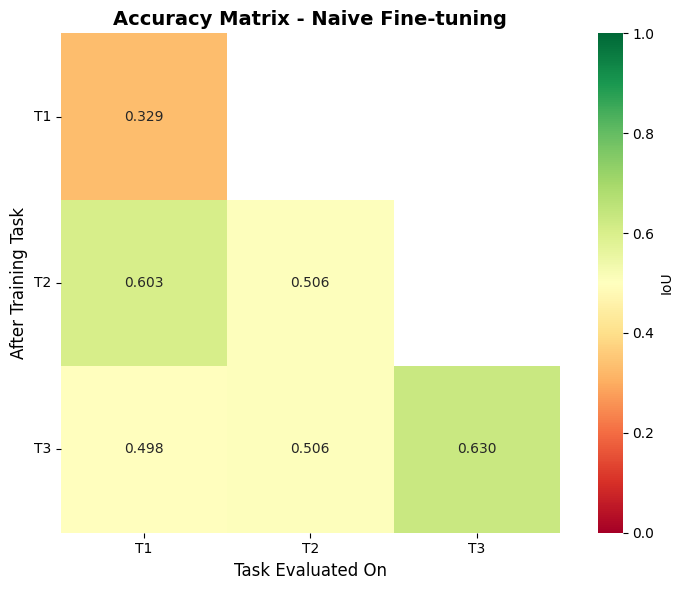

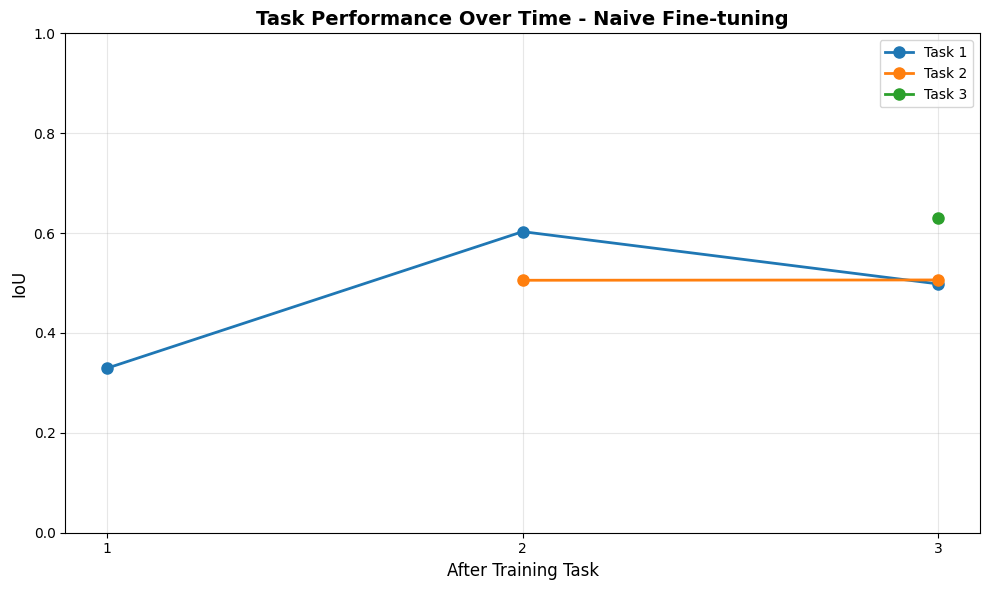

Results file not found: /content/drive/MyDrive/FYP_Models/cl_results_er.json


/tmp/ipython-input-939346385.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right')
/tmp/ipython-input-939346385.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right')
/tmp/ipython-input-939346385.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right')


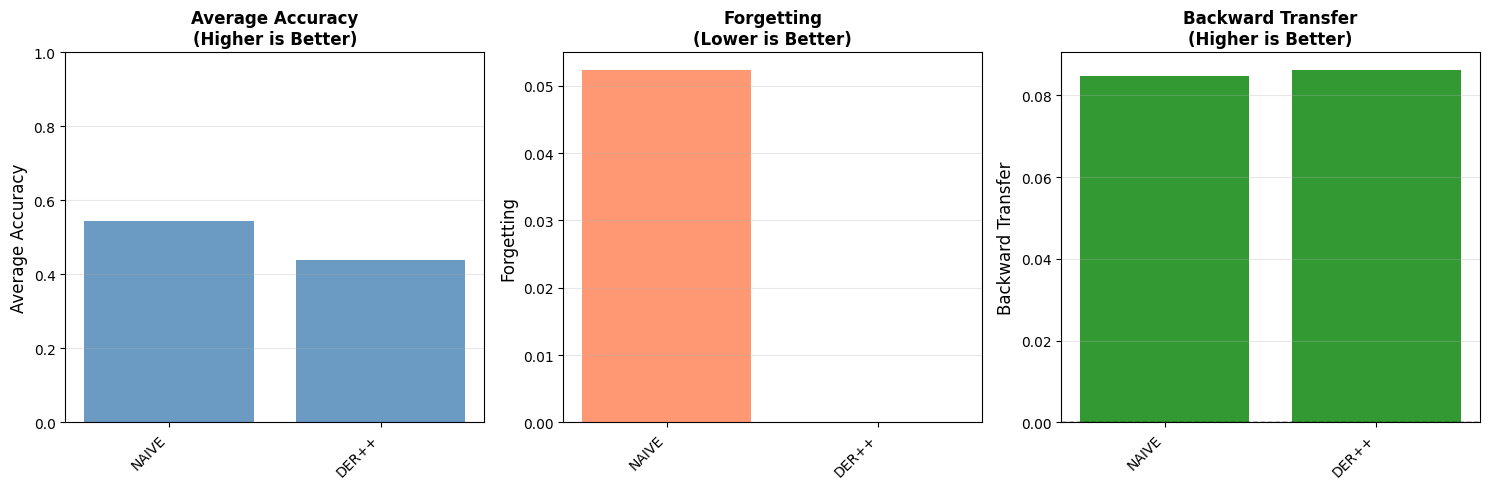

/tmp/ipython-input-939346385.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right')
/tmp/ipython-input-939346385.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right')
/tmp/ipython-input-939346385.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right')


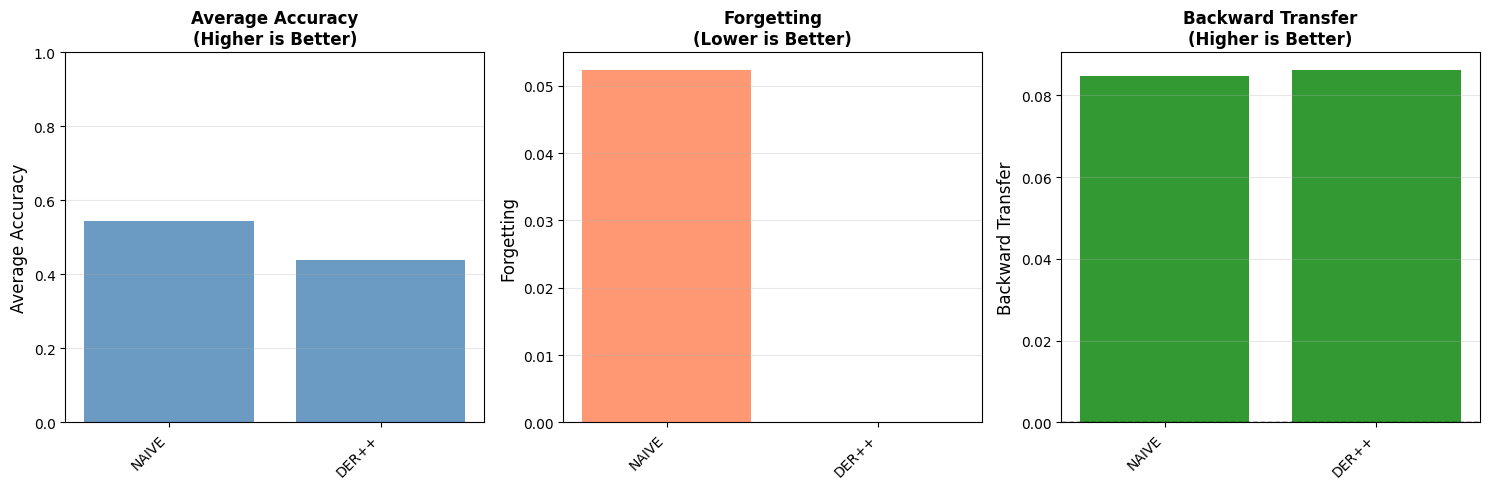

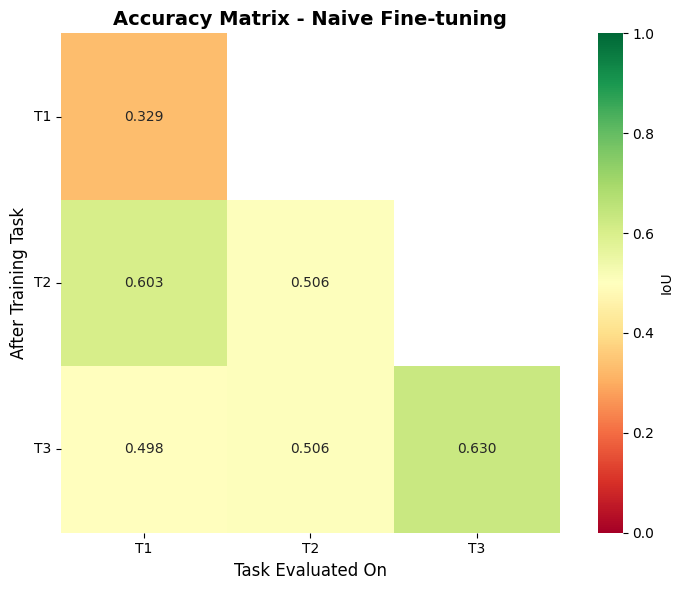

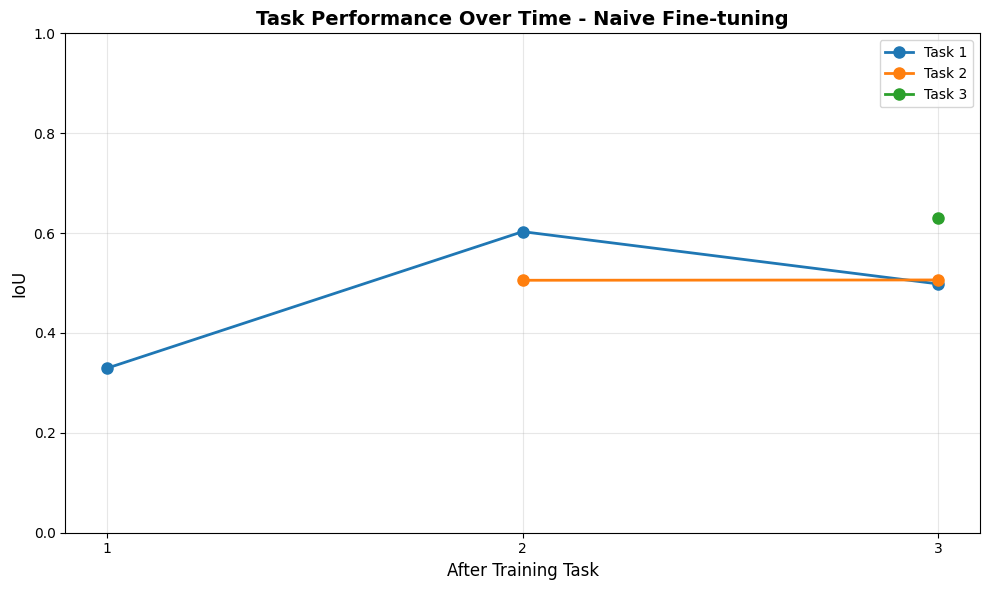

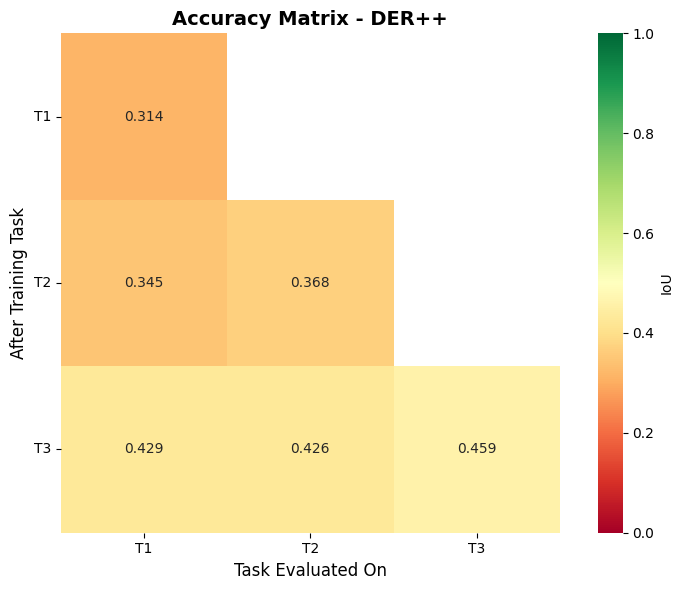

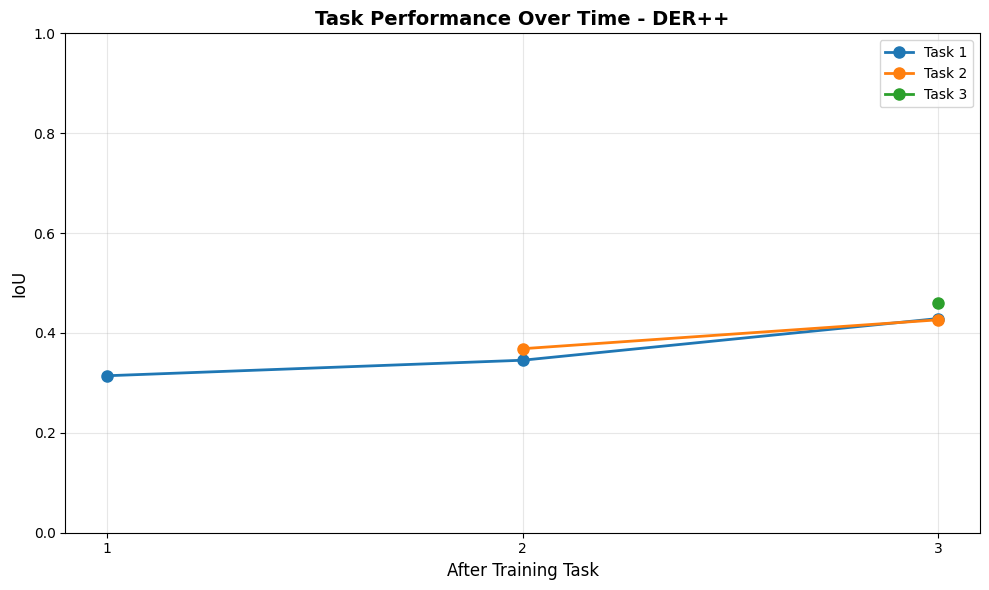

Report generation complete!
Figures saved to: /content/drive/MyDrive/FYP_Models
Model loaded from: /content/drive/MyDrive/FYP_Models/Naive_Fine-tuning_task3.pth
Loaded 50 samples from /content/dataset/valid


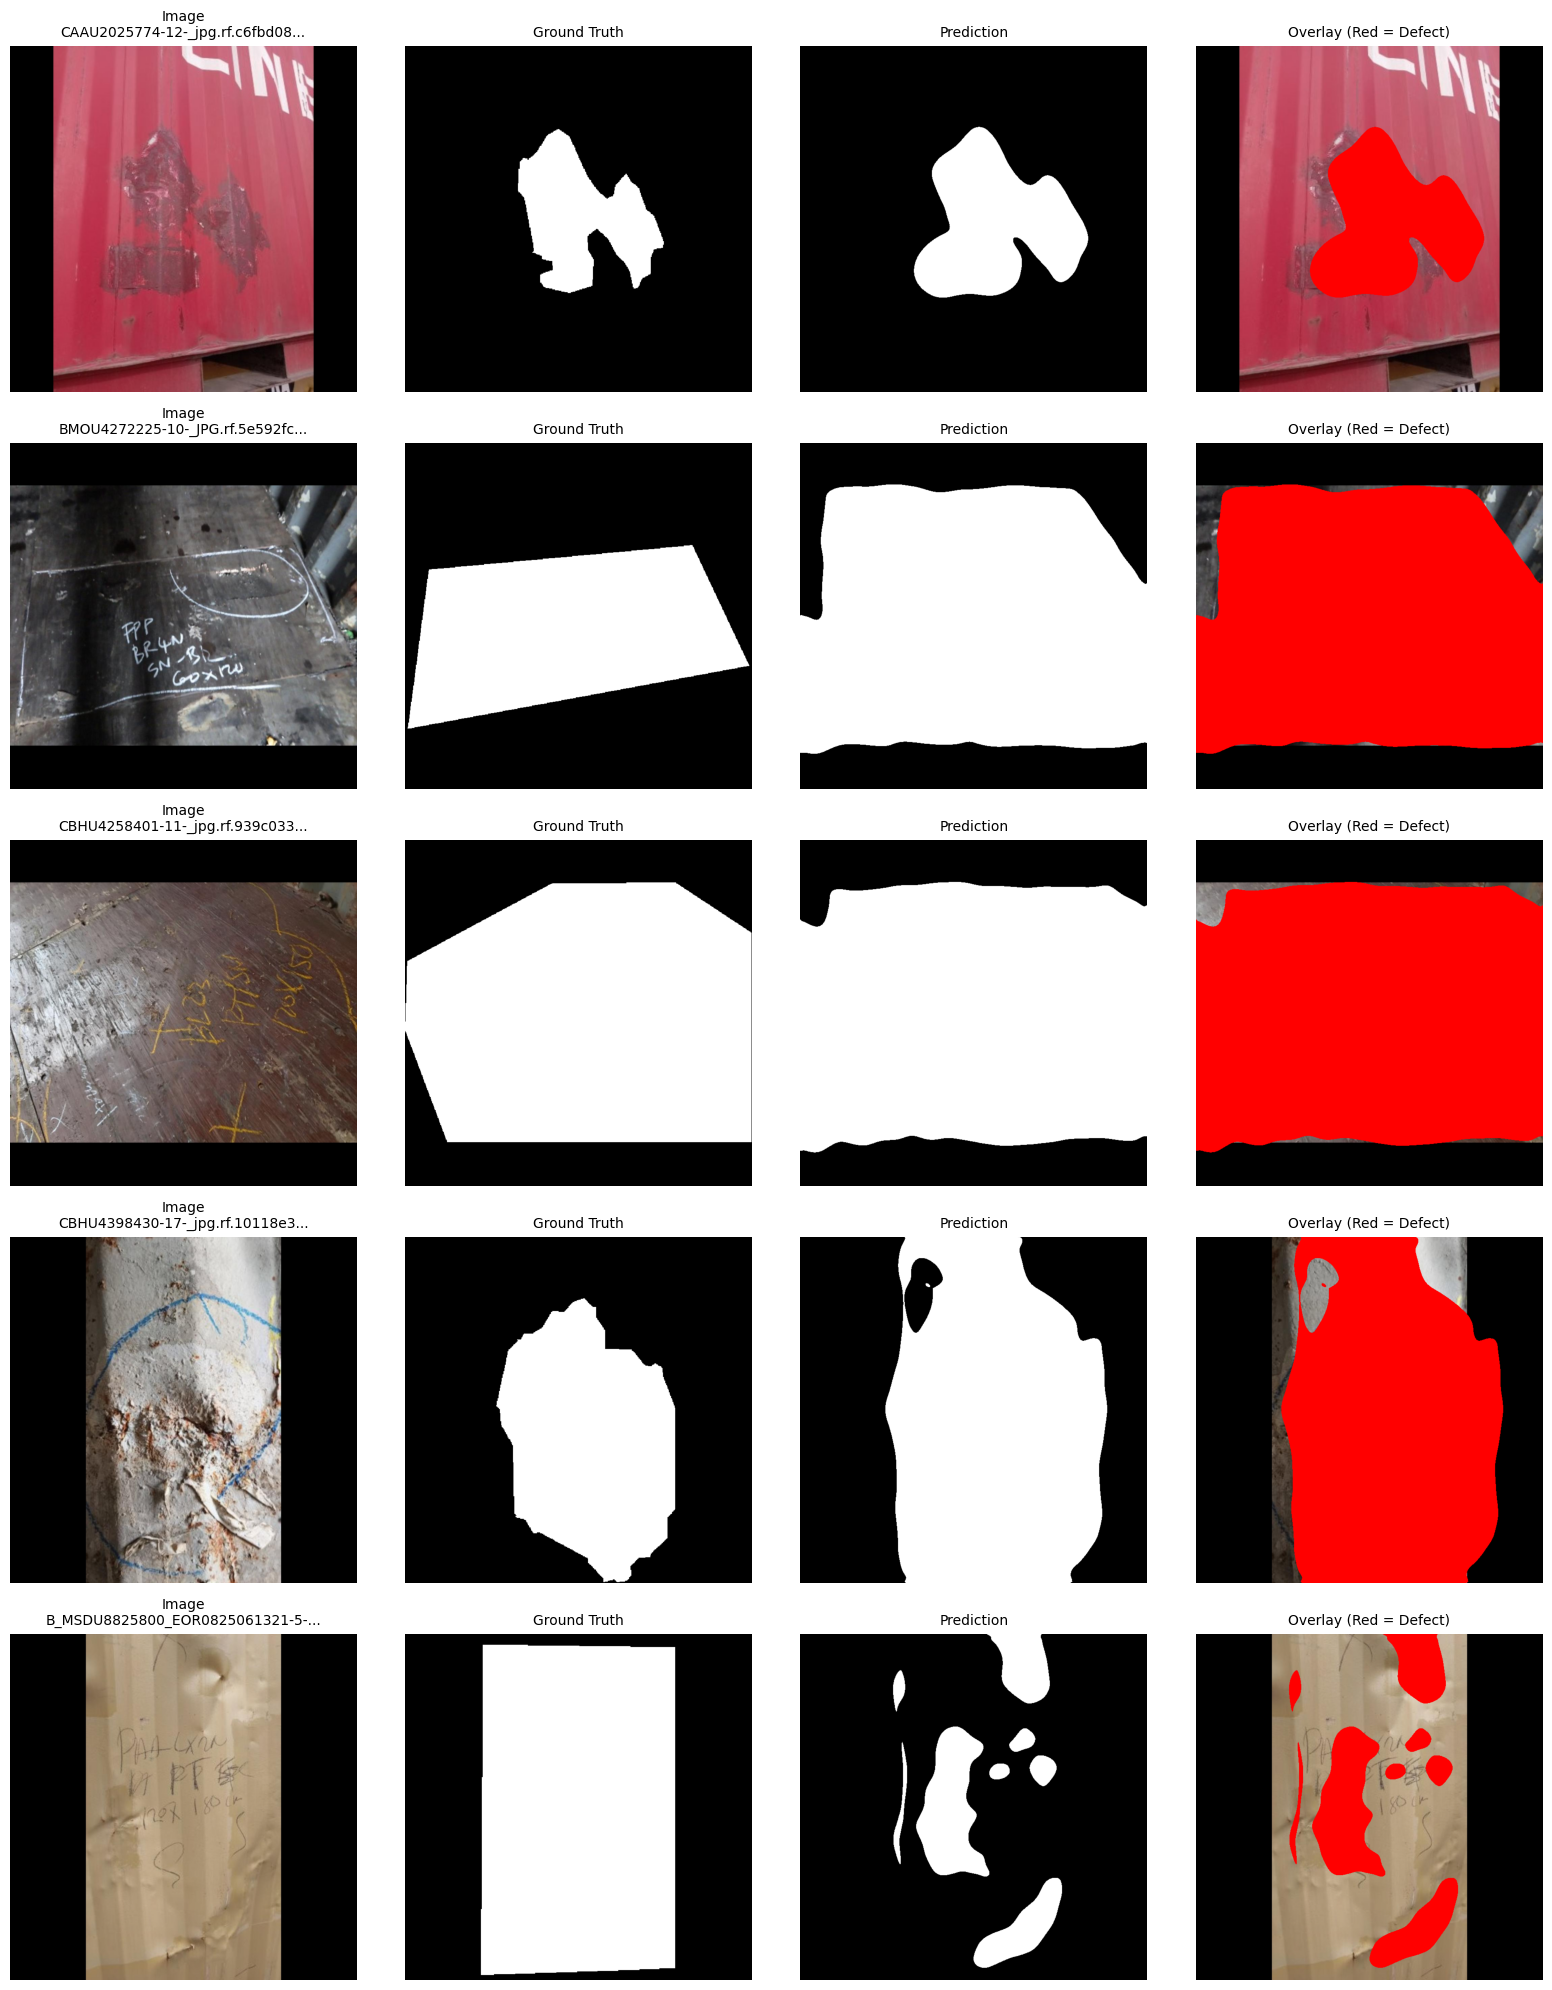

In [ ]:
# Example: Visualize Results

# Load results from a single strategy
results_naive = load_cl_results('naive')

# Plot accuracy matrix
plot_accuracy_matrix(results_naive)

# Plot performance curves
plot_task_performance_curves(results_naive)

# Compare all strategies
all_results = {
    'naive': load_cl_results('naive'),
    'er': load_cl_results('er'),
    'der++': load_cl_results('der++')
}
plot_strategy_comparison(all_results)

# Generate full report
generate_cl_report(all_results)

# Visualize predictions
model = load_trained_model(f"{SAVE_DIR}/Naive_Fine-tuning_task3.pth")
val_dataset = ContainerDefectDataset(VALID_DIR, subset_size=50)
visualize_predictions(model, val_dataset, num_samples=5)